**Training models on Covariance matrix and mean matrix of the MFCC of audio samples**

The Covariance matrix and mean matrix was found in the Music Genre Classification Notebook, and will be used to train several models here.

Models:
- Logistic Regression
- Convolutional Neural Network
    - Did not work well using the covariance matrix, so the Mel Spectrogram was used in the "Models using Mel Spectrogram" notebook

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

from sklearn.model_selection import train_test_split, validation_curve, learning_curve
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import math, random, pickle, os, operator
from tempfile import TemporaryFile

from scipy.io import wavfile
from python_speech_features import mfcc
%matplotlib inline

In [2]:
## Use GPU support
# needed to prevent error from using too much gpu memory
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


**Load Data**

In [134]:
# loading data - could try converting to pandas Dataframe instead
dataset = []
train = []
test = []
with open("feat.dat", 'rb') as f:
    while True:
        try:
            dataset.append(pickle.load(f))
        except EOFError:
            f.close()
            break
    


In [241]:
# convert data to Pandas DataFrame
flattened = []
for x in dataset:   
    flattened.append(list(x[0]) + list(x[1].flatten()) + [x[2]])

cols = [['m' +str(i) for i in range(13)]+['c'+str(i) for i in range(169)]+["Genre"]]
df = pd.DataFrame(flattened, columns=cols)
    

In [242]:
df.head()


,m0,m1,m2,m3,m4,m5,m6,m7,m8,m9,...,c160,c161,c162,c163,c164,c165,c166,c167,c168,Genre
0,76.502611,-1.961417,-15.774347,3.831419,-10.473326,1.311828,-19.393732,5.286790,-16.631725,5.353444,...,3.786696,-0.021175,-14.523117,-12.995331,-3.843489,-14.831619,2.251195,29.282607,64.650762,1
1,66.931650,0.718853,-3.267830,4.181200,-8.050941,6.448259,-17.768517,14.091810,-18.332536,3.685560,...,-16.026806,-13.013754,18.476615,11.603178,-3.788941,-17.738734,-8.665845,18.410328,90.762876,1
2,78.774103,3.039700,-19.024435,-0.983591,-14.699337,7.586562,-12.823053,1.892920,-14.865326,3.595252,...,-18.087720,-6.627783,-2.016122,-12.890326,-3.702126,-3.862404,0.221521,-9.624113,83.777252,1
3,66.696107,9.211514,-4.532876,5.027148,-8.254011,8.101201,-9.676610,9.824043,-6.735213,10.332956,...,-21.272778,-13.864303,13.764830,4.091590,-5.564044,-11.718776,-10.097750,4.902070,69.758813,1
4,71.972846,0.506410,-23.834838,-2.181944,-29.875498,0.719521,-19.039014,-1.353935,-13.370416,5.069944,...,-15.531564,9.558282,14.068872,-4.271712,-29.419962,13.653176,6.385477,7.264809,102.319498,1


The model now has 183 features and 1000 training examples
- 13 - mean for each cepstral coefficient
- 169 - elements of 13x13 covariance matrix
- 1 - genre label (1-10)

**FEATURE ANALYSIS**


- Split data into training and test data (and randomize)
- normalise values

In [243]:
X = df.iloc[:,:-1]
y = df[["Genre"]]

In [244]:
# normalisation
# standard scaler performs better than min max processor - between 0 and 1
# - probably since it preserves the negative and positive values
# - it may also converge quicker
min_max_scaler = preprocessing.StandardScaler()
X_scaled = min_max_scaler.fit_transform(X)
# apply normalizer
X_norm = pd.DataFrame(X_scaled)

X_norm.columns = X.columns


In [245]:
y

,Genre
0,1
1,1
2,1
3,1
4,1
...,...
995,10
996,10
997,10
998,10


In [246]:
# split into train and test data with separate labels:
X_train, X_test, y_train, y_test = train_test_split(X_norm,y, test_size=0.1, random_state=420)

In [247]:
X_train

,m0,m1,m2,m3,m4,m5,m6,m7,m8,m9,...,c159,c160,c161,c162,c163,c164,c165,c166,c167,c168
753,0.324414,-0.129911,0.451255,-2.100491,0.069541,-2.735649,2.174495,-2.143841,-0.503978,-0.326778,...,0.109965,-1.395237,0.545093,0.128219,0.000742,4.121626,-0.679685,-0.962150,1.360786,1.708399
894,0.413000,0.249725,-0.542112,-0.738699,1.657118,-0.028496,0.436719,-0.779975,0.916687,0.301654,...,0.609829,-0.114878,-1.828992,-0.314283,0.251265,-0.521169,0.244801,-0.321018,-0.269711,-0.209186
852,0.504429,-1.120477,2.051930,-0.705474,1.430730,-0.354240,1.246680,0.115724,1.408088,-1.592473,...,0.728586,1.839018,0.911773,1.057311,0.729928,-0.557491,0.418238,0.848465,0.573685,0.287174
346,0.182115,-0.265140,-0.390672,-0.373524,-0.785140,0.614134,0.414218,0.876076,-0.907639,1.575361,...,-0.740360,-0.978161,0.540201,3.036502,0.419780,-0.993932,0.637347,0.396673,-0.319894,0.101487
129,-1.418247,0.958260,-1.759171,-0.495696,-1.217841,-0.531072,-0.991686,0.301502,-0.680882,0.595745,...,0.244109,-0.407230,0.097293,0.569101,0.552478,0.474079,-1.559474,-1.192572,1.418135,1.720505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799,0.270112,-0.356234,1.924927,-1.657343,1.264483,-1.538151,1.714976,-1.761312,0.982302,0.617699,...,-0.736642,-0.563758,0.396159,0.905677,0.908408,0.314739,0.955612,0.301354,-0.734775,-0.578525
575,0.836979,-0.774057,-0.041764,-1.201773,0.085740,-1.756904,0.203984,-0.810223,0.836356,-0.596034,...,-0.813021,-0.596388,-0.405800,0.248337,0.177381,-0.720140,0.373762,1.051508,-0.911721,-1.246000
390,0.102735,-0.759999,-0.267127,0.099368,-0.369777,1.200677,-1.124899,0.905220,-0.687332,0.716586,...,0.213379,0.506083,0.126175,0.223781,0.019575,-0.531011,-0.113476,0.215231,-0.178004,-0.898507
72,0.359062,-0.662445,1.059405,0.595044,-3.278725,-0.294056,-1.555517,-0.298002,0.544868,-1.636101,...,0.025403,1.066014,0.991613,0.084713,0.092987,0.363359,0.991457,0.596062,0.133435,-0.883249


<strong>Models</strong>

**Logistic Regression**
- Accuracy of 78% using:

LogisticRegression(random_state=2, solver='lbfgs', multi_class='ovr', max_iter=8000, C=0.1)



In [248]:
# Create and fit model
# lbfgs solver used for multiclass problem - quicker than saga
# 
log_regr = LogisticRegression(n_jobs=-1,random_state=2, solver='lbfgs', multi_class='ovr', max_iter=1000, C=0.01)
log_regr.fit(X_train, y_train.values.ravel())

LogisticRegression(C=0.01, max_iter=1000, multi_class='ovr', n_jobs=-1,
                   random_state=2)

In [257]:
# check importance of features on average
weights = log_regr.coef_.sum(axis=0)
imp = abs(weights) > 1
impl = []
for i in range(len(imp)):
    if imp[i]:
        impl.append(cols[0][i])

print("Important features: ",impl)

Important features:  []


In [262]:
# Using validation curve
def plot_learning_curve(model):
    train_sizes, train_scores, valid_scores = learning_curve(model, X_train, y_train.values.ravel(),
                                                            train_sizes=np.linspace(150,700,50, dtype=int),cv=5,
                                                            scoring = 'neg_mean_squared_error')
    train_scores_mean = -train_scores.mean(axis=1)
    valid_scores_mean =-valid_scores.mean(axis=1)
    # plot learning curves
    plt.plot(train_sizes, train_scores_mean, label = "Training error")
    plt.plot(train_sizes, valid_scores_mean, label = "Validation error")
    plt.xlabel("Training size")
    plt.ylabel("MSE")
    plt.title("Learning Curve Logistic Regression Model")
    plt.legend()

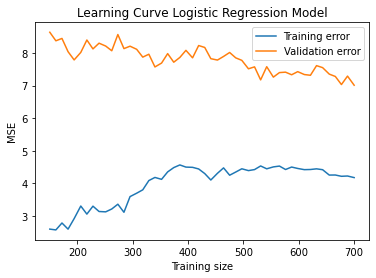

In [263]:
plot_learning_curve(log_regr)

In [265]:
# Predictions
def accuracy(model):
    pred = model.predict(X_test)
    return round(sum(y_test.values.ravel() == pred) / len(y_test), 6)

# Accuracy of logistic Regression model
print("Logistic Regression Model Accuracy: ", accuracy(log_regr))

Logistic Regression Model Accuracy:  0.78


In [267]:
# Alternatively:
log_regr.score(X_test, y_test)

0.78

**Overfitting**

From the learning curve above, it is apparent that more training data could help the validation curve converge towards the training curve and decrease error. This is done in the "Adding more data" notebook (or below).

- increasing the strength of regularisation (decreasing C from 1 to 0.01) helped overfitting (accuracy went from 71% to 76%)


Could try to decrease the number of features through PCA
- could use PCA to find the K most significant components of the coefficient matrix

In [268]:
# will only carry out PCA on MFCC coefficient matrix features
X_m = X.iloc[:,:13]
X_c = X.iloc[:,13:]


In [286]:
# use PCA to almost flatten out the 169 covariance matrix (13x13) into 13 principal components
from sklearn.decomposition import PCA

pca_accuracy = [];

def eval_PCA(model, K):

    pca = PCA(n_components=K)
    principal_components = pca.fit_transform(X_c)
    pcaDf = pd.DataFrame(data = principal_components, columns = [['p'+str(i) for i in range(K)]])
    
    #recombine X_m
    X_pca = pd.concat([X_m, pcaDf], axis=1)
    # normalise
    min_max_scaler = preprocessing.StandardScaler()
    X_pca_scaled = min_max_scaler.fit_transform(X_pca)
    X_pca_norm = pd.DataFrame(X_pca_scaled)

    X_pca_norm.columns = X_pca.columns

    # split into train and test data with separate labels:
    X_train, X_test, y_train, y_test = train_test_split(X_pca_norm,y, test_size=0.1, random_state=420)
    
    log_regr.fit(X_train, y_train.values.ravel())
    plot_learning_curve(model)
    
    pca_accuracy.append((K, model.score(X_test, y_test)))

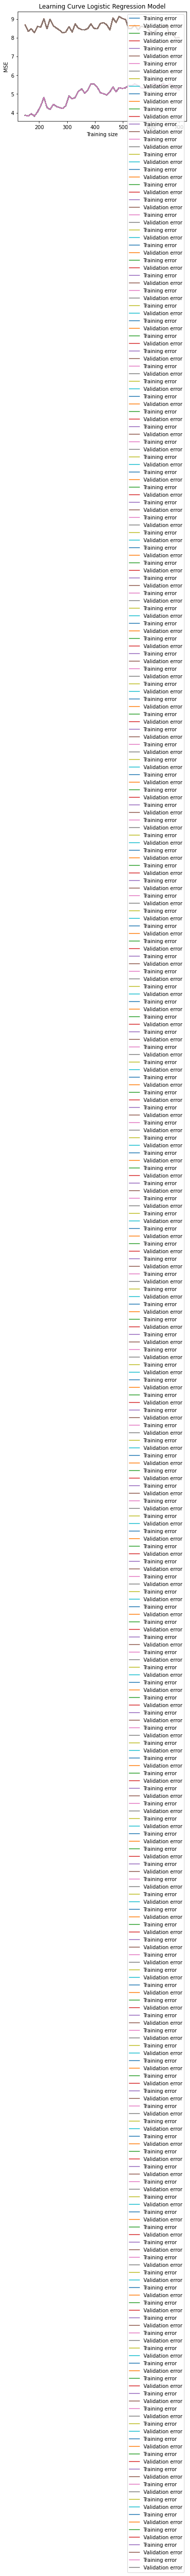

In [287]:
# evalute accuracy for range of K values
for i in range(169):
    eval_PCA(log_regr,i)

In [294]:
sorted_pca_accuracy = sorted(pca_accuracy, key=lambda acc: acc[1], reverse=True)
sorted_pca_accuracy

[(57, 0.77),
 (49, 0.75),
 (50, 0.75),
 (51, 0.75),
 (53, 0.75),
 (54, 0.75),
 (55, 0.75),
 (70, 0.75),
 (72, 0.75),
 (77, 0.75),
 (80, 0.75),
 (122, 0.75),
 (130, 0.75),
 (42, 0.74),
 (44, 0.74),
 (47, 0.74),
 (48, 0.74),
 (52, 0.74),
 (56, 0.74),
 (58, 0.74),
 (63, 0.74),
 (67, 0.74),
 (68, 0.74),
 (69, 0.74),
 (71, 0.74),
 (73, 0.74),
 (78, 0.74),
 (81, 0.74),
 (82, 0.74),
 (83, 0.74),
 (84, 0.74),
 (85, 0.74),
 (86, 0.74),
 (87, 0.74),
 (103, 0.74),
 (116, 0.74),
 (119, 0.74),
 (126, 0.74),
 (145, 0.74),
 (146, 0.74),
 (147, 0.74),
 (148, 0.74),
 (150, 0.74),
 (151, 0.74),
 (152, 0.74),
 (153, 0.74),
 (154, 0.74),
 (166, 0.74),
 (38, 0.73),
 (39, 0.73),
 (40, 0.73),
 (45, 0.73),
 (46, 0.73),
 (59, 0.73),
 (61, 0.73),
 (64, 0.73),
 (65, 0.73),
 (66, 0.73),
 (74, 0.73),
 (75, 0.73),
 (76, 0.73),
 (79, 0.73),
 (104, 0.73),
 (111, 0.73),
 (114, 0.73),
 (118, 0.73),
 (120, 0.73),
 (121, 0.73),
 (142, 0.73),
 (144, 0.73),
 (149, 0.73),
 (155, 0.73),
 (165, 0.73),
 (167, 0.73),
 (26, 0.72

In [272]:
log_regr.score(X_test, y_test)

0.75

It seems like reducing the number of features with PCA does not really help the accuracy of the model, as the best accuracy with PCA is 77% with 57 principal components (which is still worse than the 78% accuracy achieved previously).

**Try using a Convolutional Neural Network model on this MFCC structured data**
- Using Conv2D
    - need to have features in a 2D array
    
    

- This does not work well
    - Usually deep learning techniques like CNNs are used for unstructured data like spectrograms. Therefore, the next notebook "4-Models using Mel Spectrogram" will dive into using the spectrograms of the audio samples to train a CNN.



In [155]:
# convert features to 2d array 14x13
X_2d_train = np.zeros(shape=(len(X_train), 14,13,1))
for i in range(len(X_train)):
    X_2d_train[i] = X_train.iloc[i].to_numpy().reshape(14,13,1)

In [156]:
X_2d_train.shape

(900, 14, 13, 1)

In [158]:
X_2d_train

array([[[[ 0.32441438],
         [-0.12991118],
         [ 0.45125494],
         ...,
         [-0.96608707],
         [-2.43722175],
         [-0.3605362 ]],

        [[ 0.08269728],
         [ 1.15384227],
         [-1.37083345],
         ...,
         [-0.93247899],
         [ 1.11220365],
         [ 1.21290301]],

        [[ 1.15384227],
         [ 1.09790486],
         [ 0.7109872 ],
         ...,
         [ 0.10587912],
         [-0.84024776],
         [-1.85442824]],

        ...,

        [[-0.93247899],
         [ 0.10587912],
         [ 0.97487138],
         ...,
         [ 1.08517047],
         [-0.7835952 ],
         [-0.96214985]],

        [[ 1.11220365],
         [-0.84024776],
         [-2.97015949],
         ...,
         [-0.7835952 ],
         [ 2.22359325],
         [ 1.36078646]],

        [[ 1.21290301],
         [-1.85442824],
         [-3.37825564],
         ...,
         [-0.96214985],
         [ 1.36078646],
         [ 1.70839881]]],


       [[[ 0.41300004],


In [157]:
model = Sequential()

model.add(Conv2D(64, (3,3), input_shape = X_2d_train.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten()) # as it was 2D, dense needs 1D
model.add(Dense(64))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=['accuracy'])

model.fit(X_2d_train, y_train, batch_size=100, epochs=10, validation_split=0.1)

Epoch 1/10
9/9 [==============================] - 1s 33ms/step - loss: -14.0793 - accuracy: 0.1010 - val_loss: -72.3828 - val_accuracy: 0.1000
Epoch 2/10
9/9 [==============================] - 0s 10ms/step - loss: -100.7195 - accuracy: 0.0907 - val_loss: -265.4739 - val_accuracy: 0.1000
Epoch 3/10
9/9 [==============================] - 0s 10ms/step - loss: -326.3871 - accuracy: 0.1062 - val_loss: -713.1882 - val_accuracy: 0.1000
Epoch 4/10
9/9 [==============================] - 0s 10ms/step - loss: -833.4907 - accuracy: 0.0914 - val_loss: -1633.7915 - val_accuracy: 0.1000
Epoch 5/10
9/9 [==============================] - 0s 9ms/step - loss: -1819.5851 - accuracy: 0.0965 - val_loss: -3366.5708 - val_accuracy: 0.1000
Epoch 6/10
9/9 [==============================] - 0s 10ms/step - loss: -3698.6303 - accuracy: 0.1053 - val_loss: -6408.0581 - val_accuracy: 0.1000
Epoch 7/10
9/9 [==============================] - 0s 10ms/step - loss: -6972.0616 - accuracy: 0.1053 - val_loss: -11436.4248 - v

Using covariance matrix and mean matrix in CNN didn't seem to train well at all. Instead, I'll use the Mel spectogram (MFCC before carrying out DCT) as features (seen in CNN with spectrograms Notebook).